In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

1. функція, що генерує випадкову вибірку суміші нормальних розподілів

In [29]:
def GenerateNormalMix(Ms, Ds, p, size=500):
    if not (len(Ms) == len(Ds) == len(p)):
        raise ValueError("not (len(Ms) == len(Ds) == len(p).")

    K = len(p)
    x_vals = np.arange(K)

    control_samples = stats.rv_discrete(name='custm', values=(x_vals, p)).rvs(size=size)
    
    normal_samples = np.zeros((K, size))
    for i,(m,d) in enumerate(zip(Ms, Ds)):
        normal_samples[i] = stats.norm.rvs(loc=m, scale=d, size=size)

    result = normal_samples[ control_samples, range(size) ]

    return result

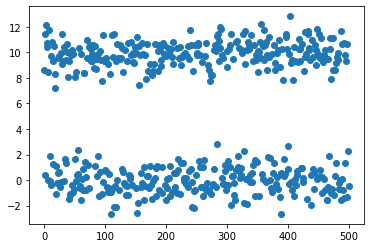

In [33]:
plt.plot(GenerateNormalMix([0, 10],[1, 1],[0.5, 0.5], 500), 'o')

# Завдання 1

$$\alpha_j^{(t+1)} = \frac{1}{n} \sum_{k=1}^n \frac{\alpha_j^{(t)}p(y_k|\varphi_j^{(t)})}{f(y_k|\vec\alpha^{(t)},\vec\varphi^{(t)})}$$
where
$$f(y_k|\theta) = f(y_k|\vec\alpha,\vec\varphi) = \sum_{i=1}^K\alpha_ip(y_k|\varphi_i) \quad \text{ - mixed pdf}$$ 

In [69]:
def EM_Task1(data, p_start, m1_start, m2_start, n_iter = 4):
    # known: variance_1, variance_2
    # unknown: m1, m2, p

    n = data.shape[0]
    d1 = 1
    d2 = 1

    # UTILITY FUNCTIONS

    # normal probability density function
    def pdf(yk, m, d):
        return np.exp(-np.square(yk-m)/(2*d)) / (np.sqrt(2*np.pi*d))
    
    # mixed probability density function
    def f(p, pdf1, pdf2):
        return p * pdf1 + (1-p) * pdf2

    # - fk is [ f(y_k|theta) : k ]
    # - pdfi is [ p(y_k|phi_i) : k ]
    def w1(p, pdf1, fk):
        return p * pdf1 / fk
    def w2(p, pdf2, fk):
        return (1-p) * pdf2 / fk

    # calculate new p
    # - p is old p
    # - w1k is [ w1(y_k|theta) : k ]
    def calculate_alpha(w1k):
        return w1k.mean()

    # calculate new m1, m2
    # - p is old p
    # - w1k is [ w1(y_k|theta) : k ]
    # - w2k is [ w2(y_k|theta) : k ]
    def calculate_phi(yk, w1k, w2k):
        new_m1 = (yk * w1k).sum() / w1k.sum()
        new_m2 = (yk * w2k).sum() / w2k.sum()
        return new_m1, new_m2

    # BEGIN ALGORITHM

    p = p_start # alpha в термінах лекції
    m1 = m1_start # phi в термінах лекції
    m2 = m2_start

    history = dict(p=[p], m1=[m1], m2=[m2])
    for step in range(n_iter):
        pdf1 = pdf(data, m1, d1)
        pdf2 = pdf(data, m2, d2)
        fk = f(p, pdf1, pdf2)
        w1k = w1(p, pdf1, fk)
        w2k = w2(p, pdf2, fk)

        p_new = calculate_alpha(w1k)
        m1_new, m2_new = calculate_phi(data, w1k, w2k)

        p, m1, m2 = p_new, m1_new, m2_new
        history['p'].append(p)
        history['m1'].append(m1)
        history['m2'].append(m2)
    
    return (p, m1, m2), history
    

Text(0.5, 1.0, 'Точки вибірки')

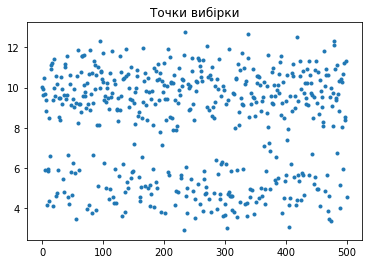

In [70]:
# генеруємо вибірку та дивимося на неї
data = GenerateNormalMix([10,5], [1,1], [2/3, 1/3], 500)
plt.plot(data, '.')
plt.title('Точки вибірки')

Text(0.5, 1.0, 'Гістограма вибірки')

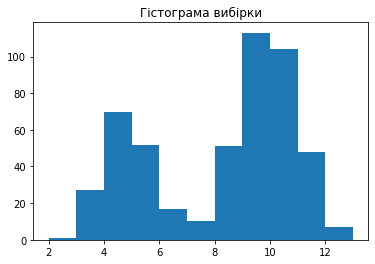

In [71]:
plt.hist(data, bins=np.arange(2,14))
plt.title('Гістограма вибірки')

result after 2 iters:  (0.18382159924608896, 4.305023202627327, 9.150647086677731)
result after 8 iters:  (0.3409999249062207, 4.952619774958564, 9.971279263786892)
result after 16 iters:  (0.34100067799707323, 4.952625142178333, 9.971282221727678)
result after 32 iters:  (0.34100067799711475, 4.952625142178631, 9.97128222172784)


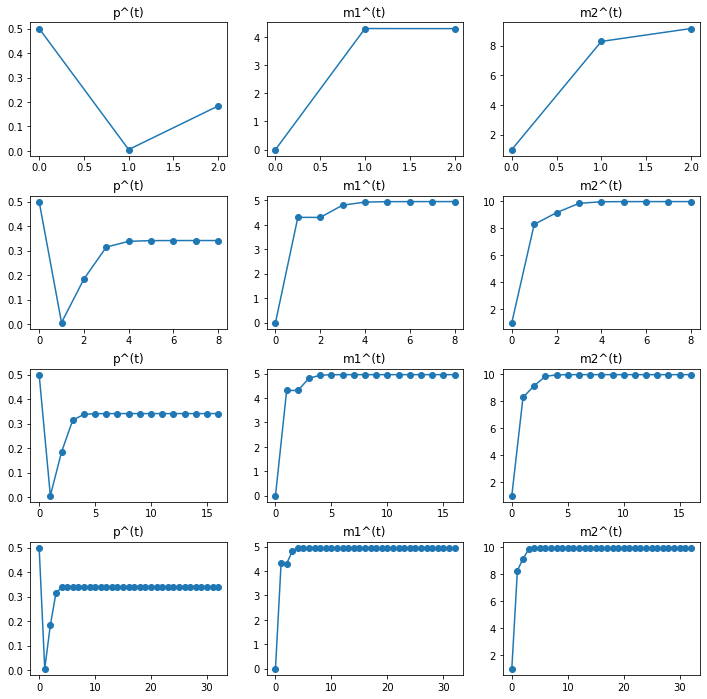

In [86]:
# Виконуємо алгоритм та будуємо графіки збіжності

fig, axs = plt.subplots(4, 3)

iterations = [2, 8, 16, 32]
for n, n_iter in enumerate(iterations):
    res, hist = EM_Task1(data, p_start=0.5, m1_start=0, m2_start=1, n_iter=n_iter)
    print(f"result after {n_iter} iters: ", res)

    ax_row = axs[n]
    ax_row[0].set_title('p^(t)')
    ax_row[0].plot(hist['p'], '-o')
    ax_row[1].set_title('m1^(t)')
    ax_row[1].plot(hist['m1'], '-o')
    ax_row[2].set_title('m2^(t)')
    ax_row[2].plot(hist['m2'], '-o')

fig.subplots_adjust(hspace=0.3)
fig.set_size_inches((12,12))

Маємо чудові результати. Алгоритм збігається та робицть це швидко. Після 4 ітерації покращення вже несуттєве.

Тепер спробуймо різні початкові значення 

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_3892\1403035624.py:36: RuntimeWarning: invalid value encountered in double_scalars
  new_m1 = (yk * w1k).sum() / w1k.sum()
C:\Users\mkrooted\AppData\Local\Temp\ipykernel_3892\1403035624.py:37: RuntimeWarning: invalid value encountered in double_scalars
  new_m2 = (yk * w2k).sum() / w2k.sum()


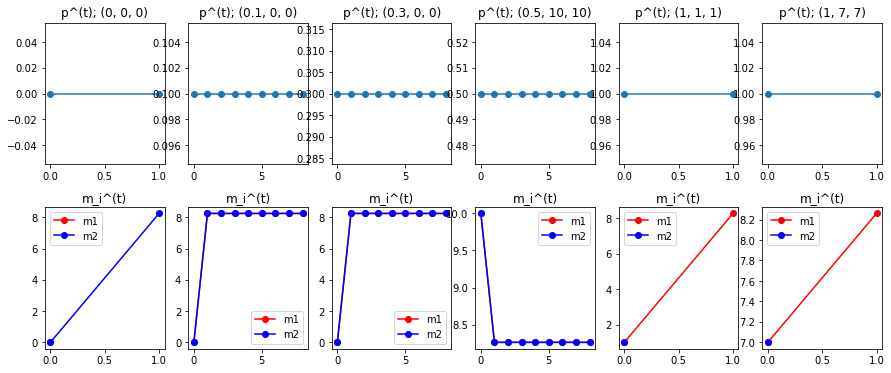

In [94]:
n_iters = 8

starts = [ 
    (0, 0, 0), 
    (0.1, 0, 0), 
    (0.3, 0, 0), 
    (0.5, 10, 10),
    (1, 1, 1), 
    (1, 7, 7), 
]

fig, axs = plt.subplots(2, 6)
for i, start in enumerate(starts):
    res, hist = EM_Task1(data, *start, n_iter=n_iters)
    axs[0][i].plot(hist['p'], 'o-')
    axs[0][i].set_title(f'p^(t); {start}')
    axs[1][i].plot(hist['m1'], 'ro-', label='m1')
    axs[1][i].plot(hist['m2'], 'bo-', label='m2')
    axs[1][i].set_title(f'm_i^(t)')
    axs[1][i].legend()
fig.set_size_inches((15,6))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

Тут показані різні варіанти однієї ситуації - однакові початкові $\mu_1$ та $\mu_2$. Алгоритм не працює.

Тепер спробуємо нормальні значення

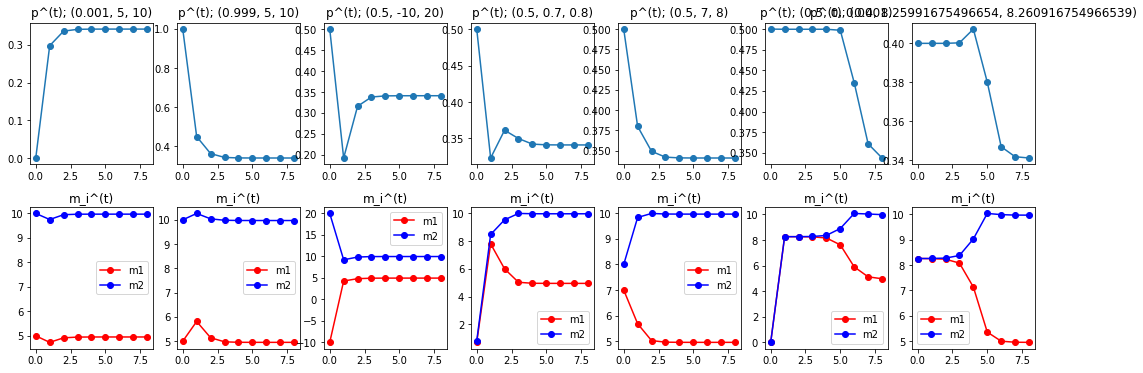

In [113]:
n_iters = 8

starts = [ 
    (0.001, 5, 10),
    (0.999, 5, 10),
    (0.5, -10, 20),
    (0.5, 0.7, 0.8),
    (0.5, 7, 8),
    (0.5, 0, 0.0001),
    (0.4, data.mean(), data.mean()+0.001)
]

fig, axs = plt.subplots(2, 7)
for i, start in enumerate(starts):
    res, hist = EM_Task1(data, *start, n_iter=n_iters)
    axs[0][i].plot(hist['p'], 'o-')
    axs[0][i].set_title(f'p^(t); {start}')
    axs[1][i].plot(hist['m1'], 'ro-', label='m1')
    axs[1][i].plot(hist['m2'], 'bo-', label='m2')
    axs[1][i].set_title(f'm_i^(t)')
    axs[1][i].legend()
fig.set_size_inches((18,6))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

Випробував різні початкові точки. найцікавіші спостереження наступні:
- алгоритм швидко знаходить $p$ за відомих $\mu_i$
- алгоритм працює навіть за $p$ близьких до 1 або до 0
- алгоритму необхідно, щоб $\mu_i$ були різні, але вони можуть бути дуже близькі
- тим не менш, початкова точка $p = 0.5; \mu_1 = 100; \mu_2=100.01$ виявилась недопустимою для алгоритму. Є сенс вважати важливою відносну різницю між $\mu_i$ 